In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# LIBRARY IMPORT
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import pearsonr
from mpl_toolkits.basemap import Basemap, cm

In [3]:
# Load intensification rate data
int_rate = pd.read_csv('Data/computed-data/computed_annual-intensification-rate_JTWC.csv')

# Load intensification duration data
int_dur = pd.read_csv('Data/computed-data/computed_annual-intensification-duration_JTWC.csv')

# Load sea surface temperature data
wind = pd.read_csv('Data/wind-shear/data_wind-shear.csv',parse_dates=['time'])

In [4]:
wind.columns = ['latitude','longitude','time','wind']

In [5]:
wind['year']  = wind['time'].dt.year
wind['month']  = wind['time'].dt.month

In [6]:
# Calculate seasonal mean for data
wind_season_mean = wind[wind['month'].between(7,9)]
wind_season_mean = wind_season_mean.groupby(['latitude','longitude','year'])['wind'].mean().reset_index()

# Convert to 360 degree coordinates
wind_season_mean.loc[wind_season_mean['longitude'] < 0, 'longitude'] = 360 + wind_season_mean['longitude']

wind_season_mean.to_csv('Data/wind-shear/computed_seasonal-wind-shear.csv',index=False)

### Duration Correlation with Seasonal wind

In [7]:
# Define function to find correlation
def find_corr_duration(data):
    return pearsonr(data['wind'].values,int_dur['Intensification Duration'].values)[0]

In [8]:
# Determine whether the cyclone move into the big box
map = Basemap(projection='cyl',resolution='c',llcrnrlon=90,\
        llcrnrlat=-31,urcrnrlon=280,urcrnrlat=65)

In [9]:
# Nino4 region
llcrnrlon =  160
urcrnrlon =  210
llcrnrlat =  -5
urcrnrlat =  5

def plot_rec(bmap, llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat):
    xs = [llcrnrlon, llcrnrlon,
          urcrnrlon, urcrnrlon,
          llcrnrlon, urcrnrlon,
          llcrnrlon, urcrnrlon]
    ys = [llcrnrlat, urcrnrlat,
          llcrnrlat, urcrnrlat,
          llcrnrlat, llcrnrlat,
          urcrnrlat, urcrnrlat]
    bmap.plot(xs, ys, latlon = True)

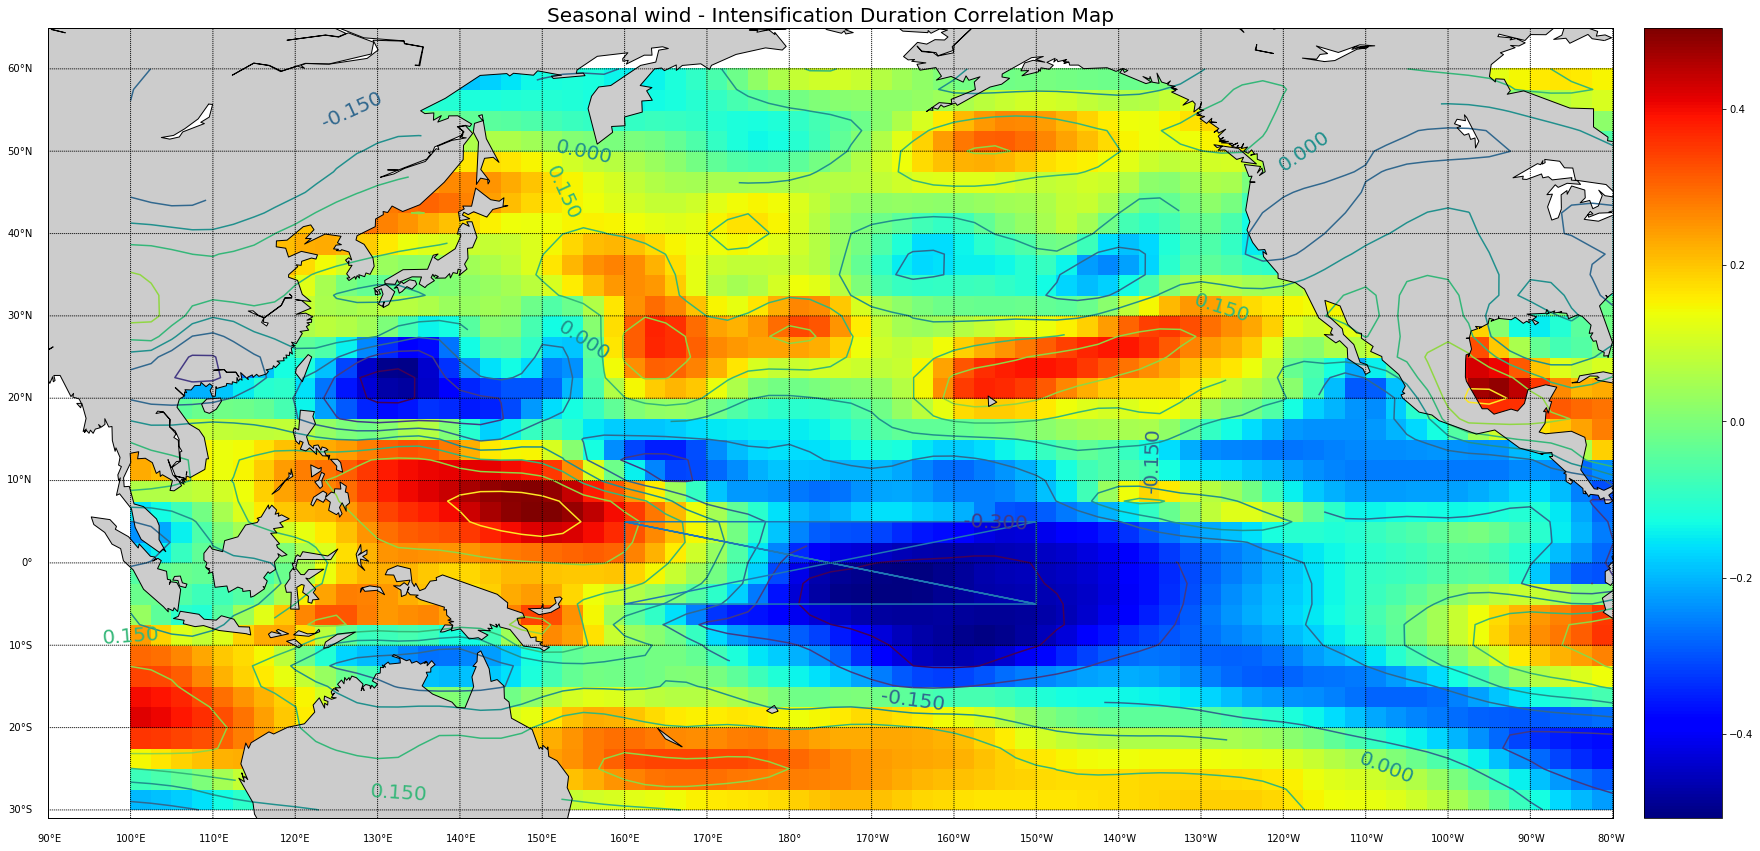

In [10]:
from matplotlib.patches import Rectangle

wind_season_corr = wind_season_mean.groupby(['latitude','longitude']).apply(find_corr_duration).rename('corr')
wind_season_corr = wind_season_corr.to_frame()
wind_season_corr = xr.Dataset.from_dataframe(wind_season_corr)

wind_season_corr = wind_season_corr.fillna(0)

data = wind_season_corr.variables['corr'][:]
lats = wind_season_corr.variables['latitude'][:]
lons = wind_season_corr.variables['longitude'][:]

im1 = map.pcolormesh(lons, lats, data,cmap=plt.cm.jet,latlon=True)

cb = map.colorbar(im1,"right", size="5%", pad="2%")

CS = plt.contour(lons.values, lats.values, data.values)
plt.clabel(CS, inline=1, fontsize=20)

# Plot nino4 region
plot_rec(map, llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat)

# make image bigger:
plt.title('Seasonal wind - Intensification Duration Correlation Map', fontsize=20)
plt.gcf().set_size_inches(30,30)

map.drawcoastlines()
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])

plt.show()

### Duration Correlation with Annual wind

In [11]:
# Calculate annual mean for data
wind_annual_mean = wind.groupby(['latitude','longitude','year'])['wind'].mean().reset_index()

# Convert to 360 degree coordinates
wind_annual_mean.loc[wind_annual_mean['longitude'] < 0, 'longitude'] = 360 + wind_annual_mean['longitude']

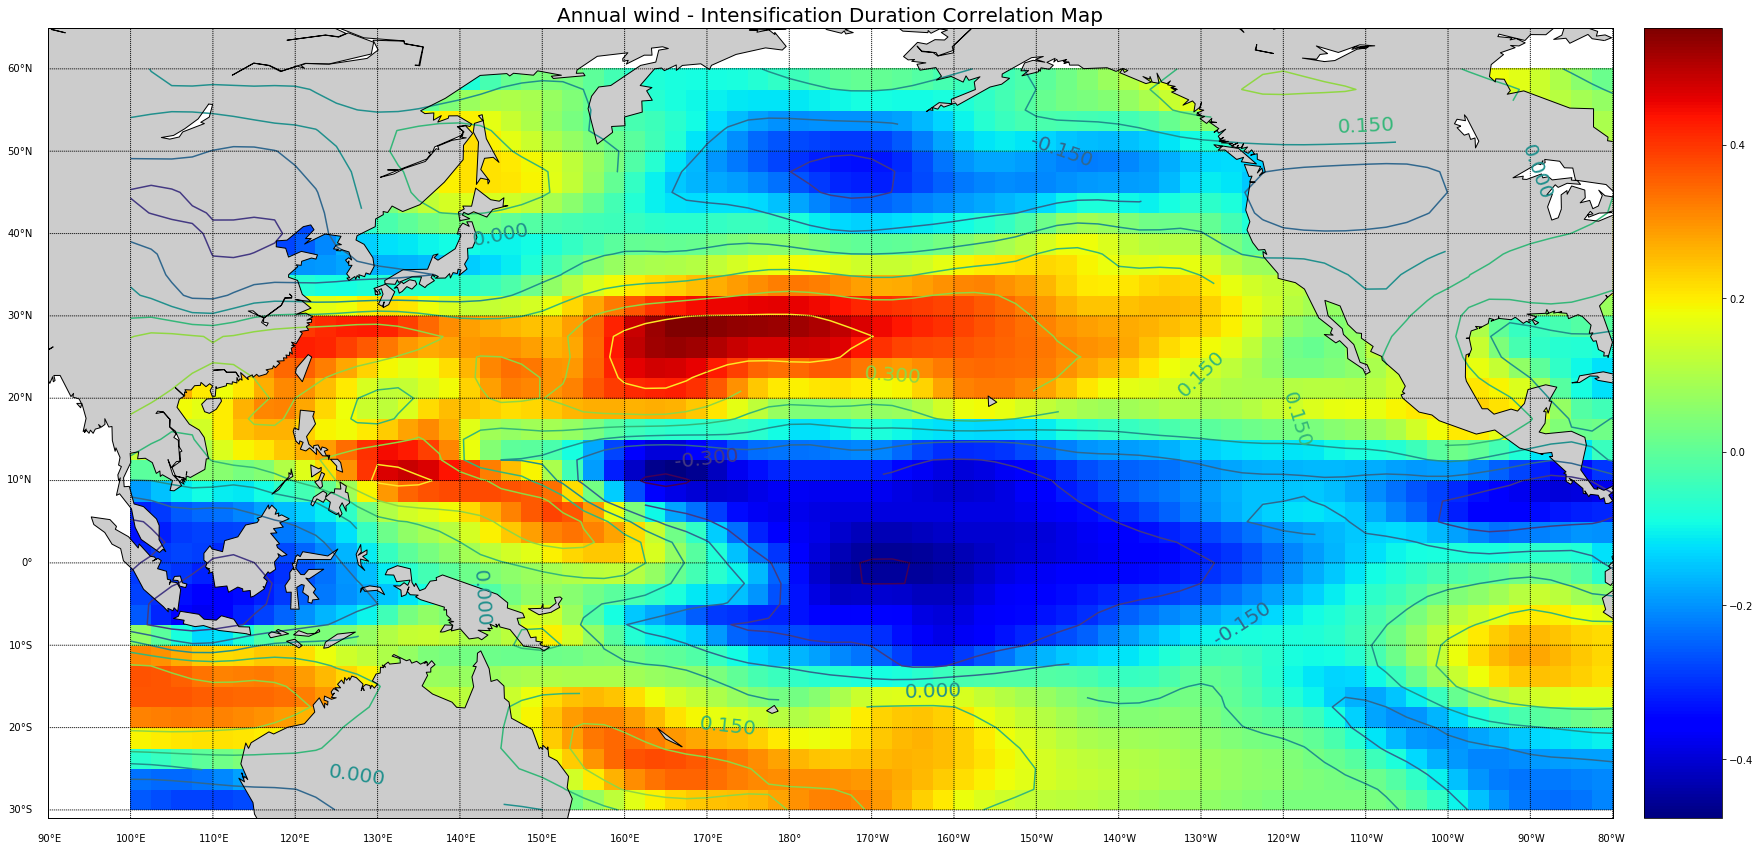

In [12]:
wind_annual_corr = wind_annual_mean.groupby(['latitude','longitude']).apply(find_corr_duration).rename('corr')
wind_annual_corr = wind_annual_corr.to_frame()

wind_annual_corr = xr.Dataset.from_dataframe(wind_annual_corr)

wind_annual_corr = wind_annual_corr.fillna(0)

data = wind_annual_corr.variables['corr'][:]
lats = wind_annual_corr.variables['latitude'][:]
lons = wind_annual_corr.variables['longitude'][:]

CS = plt.contour(lons.values, lats.values, data.values)
plt.clabel(CS, inline=1, fontsize=20)

im1 = map.pcolormesh(lons, lats, data,cmap=plt.cm.jet,latlon=True)

cb = map.colorbar(im1,"right", size="5%", pad="2%")

# make image bigger:
plt.title('Annual wind - Intensification Duration Correlation Map', fontsize=20)
plt.gcf().set_size_inches(30,30)

map.drawcoastlines()
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])

plt.show()

### Intensification Rate Correlation with Seasonal wind

In [13]:
# Define function to find correlation
def find_corr_rate(data):
    return pearsonr(data['wind'].values,int_rate['Intensification Rate'].values)[0]

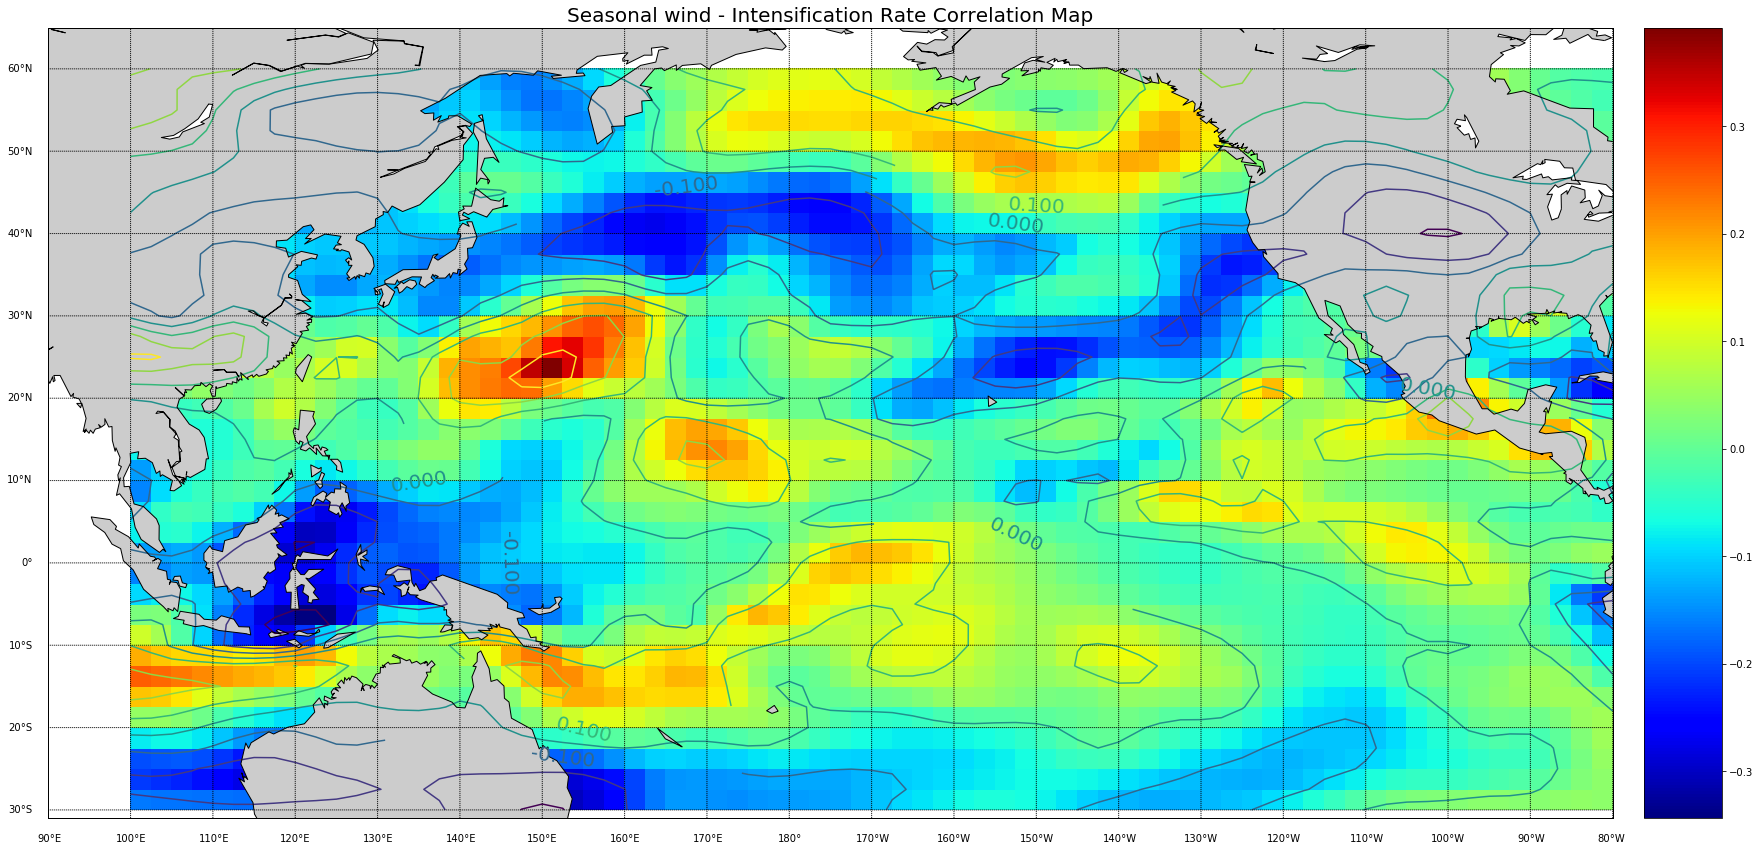

In [14]:
wind_season_corr = wind_season_mean.groupby(['latitude','longitude']).apply(find_corr_rate).rename('corr')
wind_season_corr = wind_season_corr.to_frame()
wind_season_corr = xr.Dataset.from_dataframe(wind_season_corr)

wind_season_corr = wind_season_corr.fillna(0)

data = wind_season_corr.variables['corr'][:]
lats = wind_season_corr.variables['latitude'][:]
lons = wind_season_corr.variables['longitude'][:]

CS = plt.contour(lons.values, lats.values, data.values)
plt.clabel(CS, inline=1, fontsize=20)

im1 = map.pcolormesh(lons, lats, data,cmap=plt.cm.jet,latlon=True)

cb = map.colorbar(im1,"right", size="5%", pad="2%")

# make image bigger:
plt.title('Seasonal wind - Intensification Rate Correlation Map', fontsize=20)
plt.gcf().set_size_inches(30,30)
map.drawcoastlines()
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])

plt.show()

### Intensification Rate Correlation with Annual wind

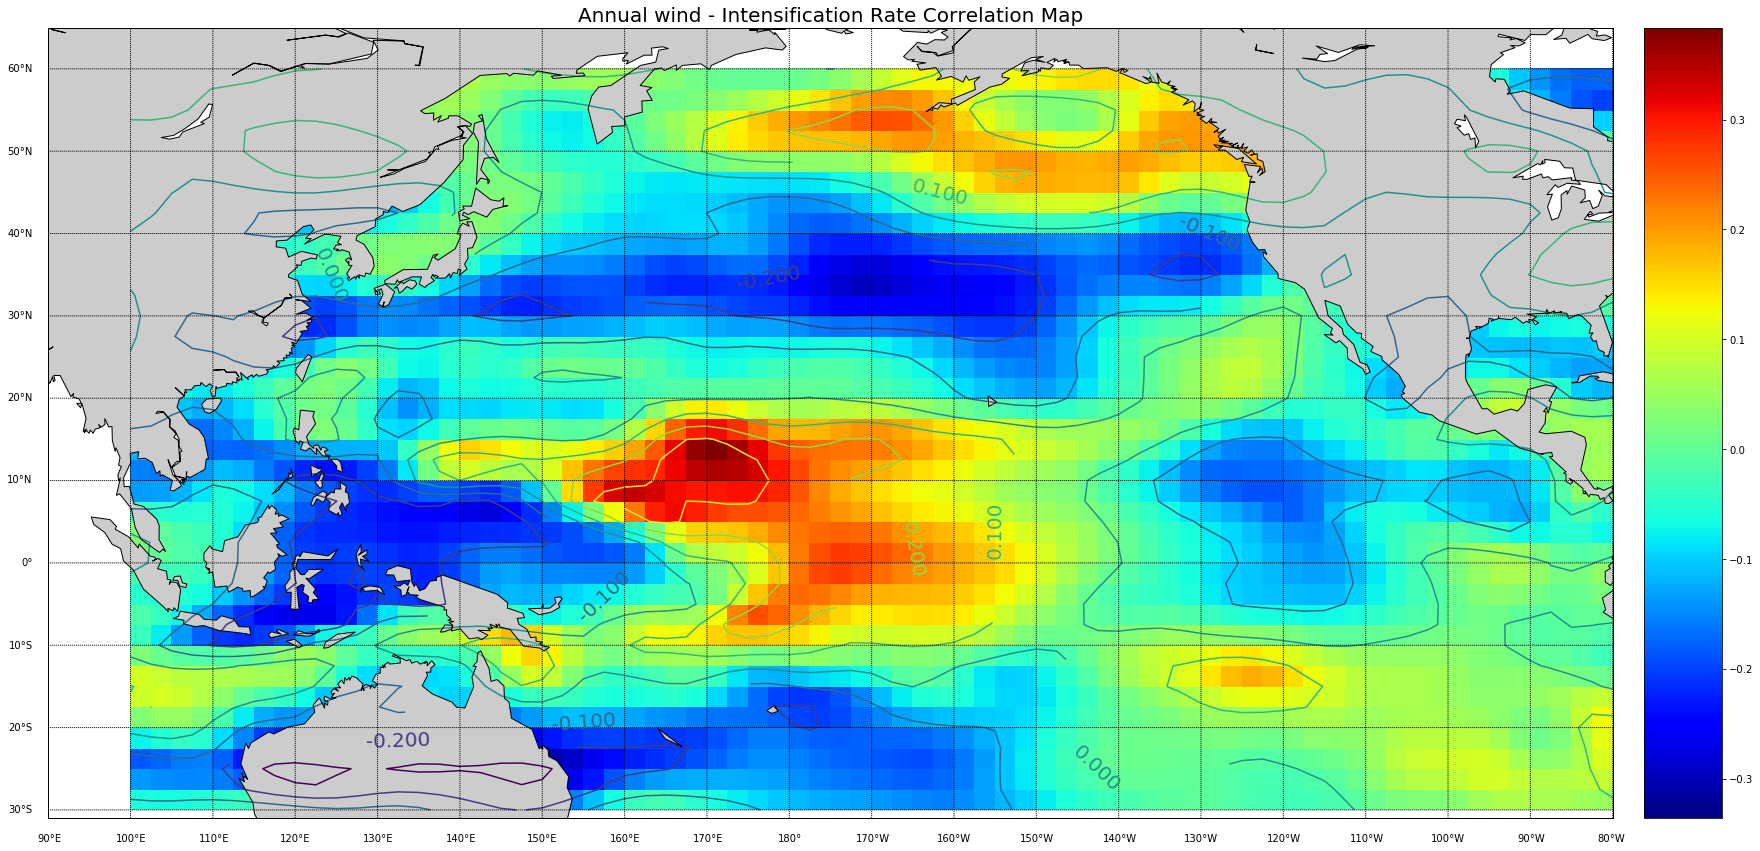

In [15]:
wind_annual_corr = wind_annual_mean.groupby(['latitude','longitude']).apply(find_corr_rate).rename('corr')
wind_annual_corr = wind_annual_corr.to_frame()

wind_annual_corr = xr.Dataset.from_dataframe(wind_annual_corr)

wind_annual_corr = wind_annual_corr.fillna(0)

data = wind_annual_corr.variables['corr'][:]
lats = wind_annual_corr.variables['latitude'][:]
lons = wind_annual_corr.variables['longitude'][:]

CS = plt.contour(lons.values, lats.values, data.values)
plt.clabel(CS, inline=1, fontsize=20)

im1 = map.pcolormesh(lons, lats, data,cmap=plt.cm.jet,latlon=True)

cb = map.colorbar(im1,"right", size="5%", pad="2%")

# make image bigger:
plt.title('Annual wind - Intensification Rate Correlation Map', fontsize=20)
plt.gcf().set_size_inches(30,30)
map.drawcoastlines()
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])

plt.show()